# Lab 5: Phân loại Văn bản với Mạng Nơ-ron Hồi quy (RNN/LSTM)

## Bước 0: Thiết lập Môi trường và Import Libraries

In [42]:
!pip install gensim
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Gensim for Word2Vec
from gensim.models import Word2Vec

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


## Bước 1: Tải và Khám phá Dữ liệu

In [43]:
# Tải dữ liệu
train_path = '/content/data/hwu/train.csv'
val_path = '/content/data/hwu/val.csv'
test_path = '/content/data/hwu/test.csv'

# Đọc dữ liệu
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)
print("\nFirst 5 samples:")
df_train.head()

Train shape: (8954, 2)
Validation shape: (1076, 2)
Test shape: (1076, 2)

First 5 samples:


,text,category
0,what alarms do i have set right now,alarm_query
1,checkout today alarm of meeting,alarm_query
2,report alarm settings,alarm_query
3,see see for me the alarms that you have set to...,alarm_query
4,is there an alarm for ten am,alarm_query


In [44]:
# Kiểm tra tên cột
print("Columns:", df_train.columns.tolist())
print("\nSample data:")
print(df_train.head())

# Thống kê về các intent (category)
print("\nNumber of unique categories:", df_train['category'].nunique())
print("\nCategory distribution:")
print(df_train['category'].value_counts().head(10))

Columns: ['text', 'category']

Sample data:
                                                text     category
0                what alarms do i have set right now  alarm_query
1                    checkout today alarm of meeting  alarm_query
2                              report alarm settings  alarm_query
3  see see for me the alarms that you have set to...  alarm_query
4                       is there an alarm for ten am  alarm_query

Number of unique categories: 64

Category distribution:
category
alarm_set              159
social_post            159
qa_definition          159
alarm_query            158
general_quirky         158
iot_hue_lightchange    158
calendar_query         158
general_commandstop    158
lists_query            158
lists_createoradd      158
Name: count, dtype: int64


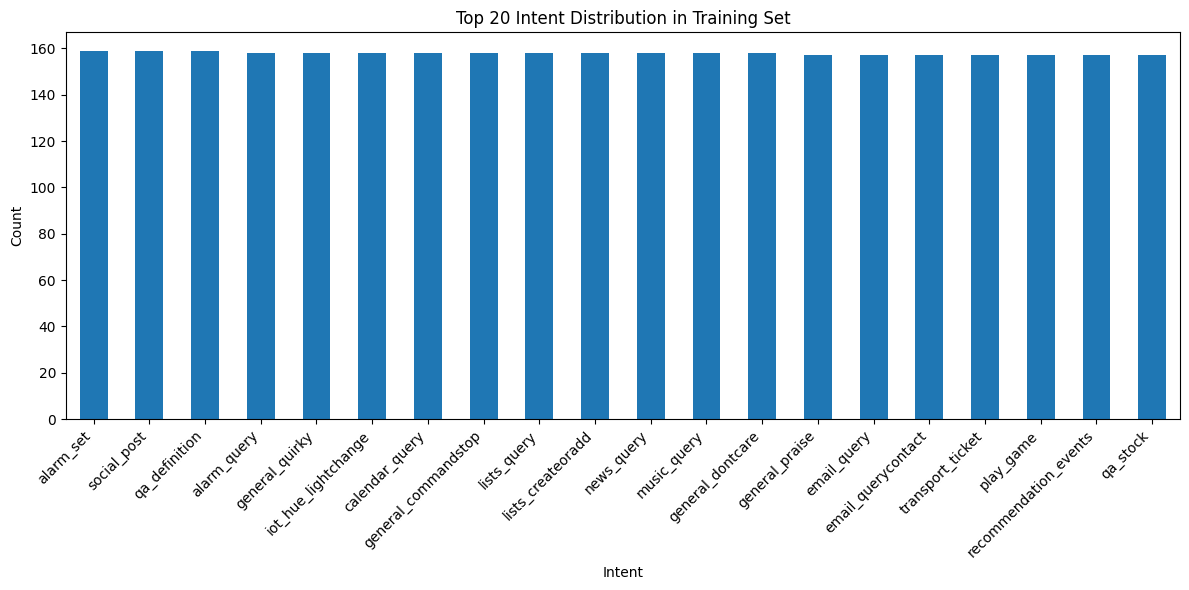


Text length statistics:
count    8954.000000
mean        6.568349
std         2.905655
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        25.000000
Name: text_length, dtype: float64


In [45]:
# Visualize phân phối intent
plt.figure(figsize=(12, 6))
df_train['category'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Intent Distribution in Training Set')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Thống kê độ dài câu
df_train['text_length'] = df_train['text'].apply(lambda x: len(x.split()))
print("\nText length statistics:")
print(df_train['text_length'].describe())

## Bước 2: Tiền xử lý Dữ liệu

In [46]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([df_train['category'], df_val['category'], df_test['category']]))

y_train = label_encoder.transform(df_train['category'])
y_val = label_encoder.transform(df_val['category'])
y_test = label_encoder.transform(df_test['category'])

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_[:10]}...")  # Show first 10

Number of classes: 64
Classes: ['alarm_query' 'alarm_remove' 'alarm_set' 'audio_volume_down'
 'audio_volume_mute' 'audio_volume_up' 'calendar_query' 'calendar_remove'
 'calendar_set' 'cooking_recipe']...


In [47]:
# Prepare text data
X_train_text = df_train['text'].values
X_val_text = df_val['text'].values
X_test_text = df_test['text'].values

print(f"Train samples: {len(X_train_text)}")
print(f"Validation samples: {len(X_val_text)}")
print(f"Test samples: {len(X_test_text)}")

Train samples: 8954
Validation samples: 1076
Test samples: 1076


## Nhiệm vụ 1: Pipeline TF-IDF + Logistic Regression (Baseline 1)

In [48]:
# Tạo pipeline
tfidf_lr_pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
)

# Huấn luyện
print("\nTraining TF-IDF + Logistic Regression...")
tfidf_lr_pipeline.fit(X_train_text, y_train)

# Dự đoán
y_pred_tfidf_lr = tfidf_lr_pipeline.predict(X_test_text)

# Đánh giá
accuracy_tfidf_lr = accuracy_score(y_test, y_pred_tfidf_lr)
f1_macro_tfidf_lr = f1_score(y_test, y_pred_tfidf_lr, average='macro')

print(f"\nAccuracy: {accuracy_tfidf_lr:.4f}")
print(f"F1-score (Macro): {f1_macro_tfidf_lr:.4f}")
print("\nClassification Report (first 10 classes):")
print(classification_report(y_test, y_pred_tfidf_lr,
                          target_names=label_encoder.classes_,
                          digits=4))


Training TF-IDF + Logistic Regression...

Accuracy: 0.8336
F1-score (Macro): 0.8300

Classification Report (first 10 classes):
                          precision    recall  f1-score   support

             alarm_query     0.9474    0.9474    0.9474        19
            alarm_remove     1.0000    0.7273    0.8421        11
               alarm_set     0.8500    0.8947    0.8718        19
       audio_volume_down     1.0000    0.7500    0.8571         8
       audio_volume_mute     0.9231    0.8000    0.8571        15
         audio_volume_up     1.0000    1.0000    1.0000        13
          calendar_query     0.5789    0.5789    0.5789        19
         calendar_remove     0.7826    0.9474    0.8571        19
            calendar_set     0.8750    0.7368    0.8000        19
          cooking_recipe     0.9286    0.6842    0.7879        19
        datetime_convert     0.7778    0.8750    0.8235         8
          datetime_query     0.7083    0.8947    0.7907        19
        email

## Nhiệm vụ 2: Pipeline Word2Vec (Trung bình) + Dense Layer (Baseline 2)

In [49]:
# Chuẩn bị dữ liệu cho Word2Vec
sentences_train = [text.lower().split() for text in X_train_text]
sentences_val = [text.lower().split() for text in X_val_text]
sentences_test = [text.lower().split() for text in X_test_text]

# Huấn luyện Word2Vec
print("\nTraining Word2Vec model...")
w2v_model = Word2Vec(
    sentences=sentences_train,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10,
    seed=42
)

print(f"Vocabulary size: {len(w2v_model.wv)}")
print(f"Vector size: {w2v_model.vector_size}")


Training Word2Vec model...
Vocabulary size: 4424
Vector size: 100


In [50]:
# Hàm chuyển câu thành vector trung bình
def sentence_to_avg_vector(sentence, model):
    """
    Chuyển một câu thành vector trung bình của các từ trong câu.
    """
    words = sentence.lower().split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        # Trả về vector 0 nếu không có từ nào trong vocab
        return np.zeros(model.vector_size)

# Chuyển đổi dữ liệu
print("Converting sentences to average vectors...")
X_train_w2v = np.array([sentence_to_avg_vector(text, w2v_model) for text in X_train_text])
X_val_w2v = np.array([sentence_to_avg_vector(text, w2v_model) for text in X_val_text])
X_test_w2v = np.array([sentence_to_avg_vector(text, w2v_model) for text in X_test_text])

print(f"X_train_w2v shape: {X_train_w2v.shape}")
print(f"X_val_w2v shape: {X_val_w2v.shape}")
print(f"X_test_w2v shape: {X_test_w2v.shape}")

Converting sentences to average vectors...
X_train_w2v shape: (8954, 100)
X_val_w2v shape: (1076, 100)
X_test_w2v shape: (1076, 100)


In [51]:
# Chuyển labels sang one-hot encoding
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Xây dựng mô hình Dense với 3 hidden layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

print("\nBuilding Word2Vec + Dense model (3 hidden layers)...")
w2v_dense_model = Sequential([
    # Layer 1: Input layer
    Dense(256, activation='relu', input_shape=(w2v_model.vector_size,)),
    BatchNormalization(),
    Dropout(0.4),

    # Layer 2: Hidden layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 3: Hidden layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    # Output layer
    Dense(num_classes, activation='softmax')
])

w2v_dense_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

w2v_dense_model.summary()


Building Word2Vec + Dense model (3 hidden layers)...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,960 (285.00 KB)

 Trainable params: 72,064 (281.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [52]:
# Huấn luyện mô hình
print("\nTraining Word2Vec + Dense model...")
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

history_w2v = w2v_dense_model.fit(
    X_train_w2v, y_train_cat,
    validation_data=(X_val_w2v, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Training Word2Vec + Dense model...
Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0563 - loss: 4.1852 - val_accuracy: 0.1533 - val_loss: 3.6463
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1788 - loss: 3.2582 - val_accuracy: 0.3030 - val_loss: 2.7994
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2280 - loss: 2.9529 - val_accuracy: 0.3569 - val_loss: 2.4514
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2729 - loss: 2.6933 - val_accuracy: 0.3838 - val_loss: 2.3128
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3077 - loss: 2.5534 - val_accuracy: 0.4173 - val_loss: 2.1710
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3295 - loss: 2.4151 - val_accuracy: 0.4303 - val_loss: 2.0735
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3380 - loss: 2.3875 - val_accuracy: 0.4303 - val_loss: 2.0455
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.36

In [53]:
# Đánh giá mô hình
print("\nEvaluating Word2Vec + Dense model...")
test_loss_w2v, test_acc_w2v = w2v_dense_model.evaluate(X_test_w2v, y_test_cat, verbose=0)

y_pred_w2v_proba = w2v_dense_model.predict(X_test_w2v, verbose=0)
y_pred_w2v = np.argmax(y_pred_w2v_proba, axis=1)

f1_macro_w2v = f1_score(y_test, y_pred_w2v, average='macro')

print(f"\nTest Loss: {test_loss_w2v:.4f}")
print(f"Test Accuracy: {test_acc_w2v:.4f}")
print(f"F1-score (Macro): {f1_macro_w2v:.4f}")


Evaluating Word2Vec + Dense model...

Test Loss: 1.4335
Test Accuracy: 0.5883
F1-score (Macro): 0.5478


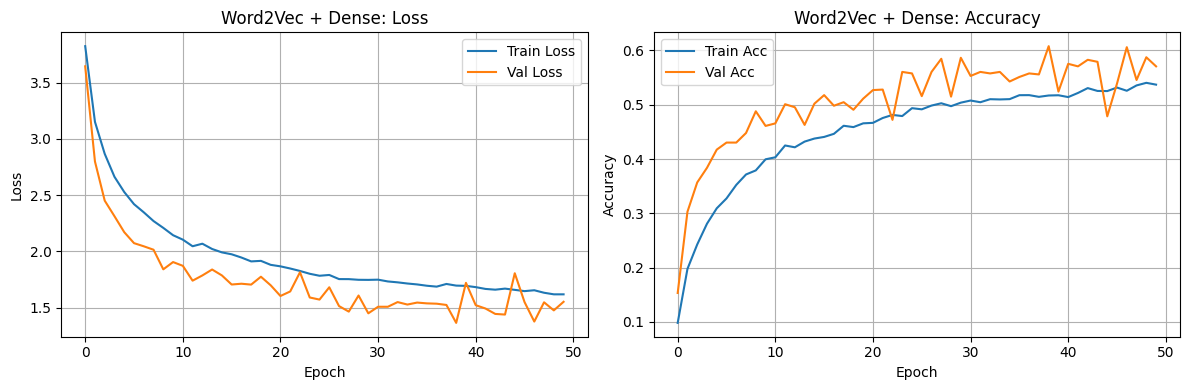

In [54]:
# Vẽ biểu đồ training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_w2v.history['loss'], label='Train Loss')
plt.plot(history_w2v.history['val_loss'], label='Val Loss')
plt.title('Word2Vec + Dense: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_w2v.history['accuracy'], label='Train Acc')
plt.plot(history_w2v.history['val_accuracy'], label='Val Acc')
plt.title('Word2Vec + Dense: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Chuẩn bị dữ liệu cho mô hình LSTM

In [55]:
# Tokenizer
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train_text)

# Chuyển text thành sequences
train_sequences = tokenizer.texts_to_sequences(X_train_text)
val_sequences = tokenizer.texts_to_sequences(X_val_text)
test_sequences = tokenizer.texts_to_sequences(X_test_text)

# Padding
max_len = 50
X_train_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(val_sequences, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post')

print(f"\nVocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Max sequence length: {max_len}")
print(f"X_train_pad shape: {X_train_pad.shape}")
print(f"X_val_pad shape: {X_val_pad.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}")


Vocabulary size: 4265
Max sequence length: 50
X_train_pad shape: (8954, 50)
X_val_pad shape: (1076, 50)
X_test_pad shape: (1076, 50)


## Nhiệm vụ 3: Mô hình Embedding (Pre-trained) + LSTM

In [56]:
# Tạo ma trận embedding từ Word2Vec
word_index = tokenizer.word_index
vocab_size_actual = min(len(word_index) + 1, vocab_size)
embedding_dim = w2v_model.vector_size

print(f"\nCreating embedding matrix...")
embedding_matrix = np.zeros((vocab_size_actual, embedding_dim))

found_words = 0
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        found_words += 1

print(f"Found {found_words}/{vocab_size_actual} words in Word2Vec model")
print(f"Coverage: {found_words/vocab_size_actual*100:.2f}%")


Creating embedding matrix...
Found 4197/4265 words in Word2Vec model
Coverage: 98.41%


In [57]:
# Xây dựng mô hình LSTM với pre-trained embeddings
print("\nBuilding LSTM model with pre-trained embeddings...")
lstm_pretrained_model = Sequential([
    Embedding(
        input_dim=vocab_size_actual,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # Đóng băng embedding layer
    ),
    LSTM(128, dropout=0.2, recurrent_dropout=0),
    Dense(num_classes, activation='softmax')
])

lstm_pretrained_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_pretrained_model.build(input_shape=(None, max_len))

lstm_pretrained_model.summary()


Building LSTM model with pre-trained embeddings...


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 50, 100)        │       426,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,004 (2.11 MB)

 Trainable params: 125,504 (490.25 KB)

 Non-trainable params: 426,500 (1.63 MB)

In [58]:
# Huấn luyện mô hình
print("\nTraining LSTM model with pre-trained embeddings...")
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_lstm_pretrained = lstm_pretrained_model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop]
)


Training LSTM model with pre-trained embeddings...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.0195 - loss: 4.1404 - val_accuracy: 0.0316 - val_loss: 3.9366
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.0302 - loss: 3.9023 - val_accuracy: 0.0362 - val_loss: 3.7836
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.0418 - loss: 3.7521 - val_accuracy: 0.0669 - val_loss: 3.6710
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.0614 - loss: 3.6615 - val_accuracy: 0.0864 - val_loss: 3.5527
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.0683 - loss: 3.5603 - val_accuracy: 0.0762 - val_loss: 3.4875
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.0716 - loss: 3.5120 - val_accuracy: 0.0976 - val_loss: 3.3975
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.0814 - loss: 3.4681 - val_accuracy: 0.0939 - val_loss: 3.4025
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms

In [59]:
# Đánh giá mô hình
print("\nEvaluating LSTM model with pre-trained embeddings...")
test_loss_lstm_pre, test_acc_lstm_pre = lstm_pretrained_model.evaluate(X_test_pad, y_test_cat, verbose=0)

y_pred_lstm_pre_proba = lstm_pretrained_model.predict(X_test_pad)
y_pred_lstm_pre = np.argmax(y_pred_lstm_pre_proba, axis=1)

f1_macro_lstm_pre = f1_score(y_test, y_pred_lstm_pre, average='macro')

print(f"\nTest Loss: {test_loss_lstm_pre:.4f}")
print(f"Test Accuracy: {test_acc_lstm_pre:.4f}")
print(f"F1-score (Macro): {f1_macro_lstm_pre:.4f}")


Evaluating LSTM model with pre-trained embeddings...
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Test Loss: 1.6899
Test Accuracy: 0.5307
F1-score (Macro): 0.5044


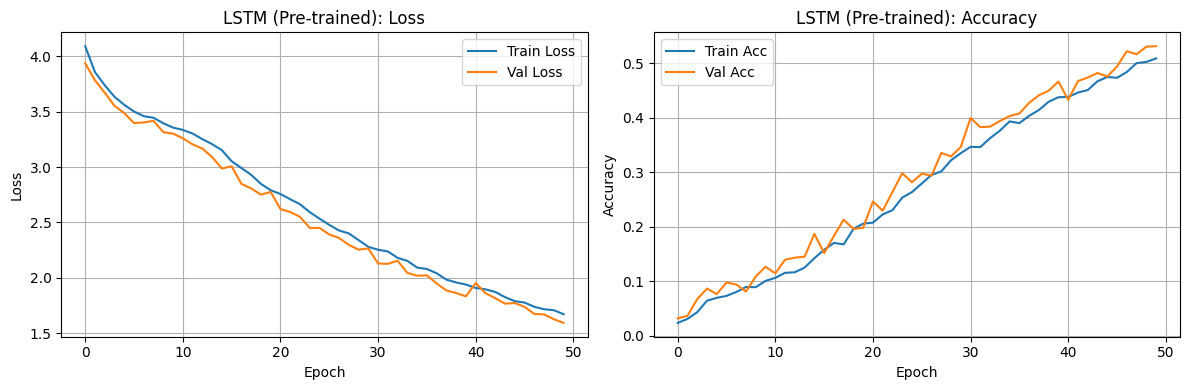

In [60]:
# Vẽ biểu đồ training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm_pretrained.history['loss'], label='Train Loss')
plt.plot(history_lstm_pretrained.history['val_loss'], label='Val Loss')
plt.title('LSTM (Pre-trained): Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm_pretrained.history['accuracy'], label='Train Acc')
plt.plot(history_lstm_pretrained.history['val_accuracy'], label='Val Acc')
plt.title('LSTM (Pre-trained): Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Nhiệm vụ 4: Mô hình Embedding (Học từ đầu) + LSTM

In [61]:
# Xây dựng mô hình LSTM với embedding học từ đầu
print("\nBuilding LSTM model with trainable embeddings from scratch...")

lstm_scratch_model = Sequential([
    # Embedding layer - học từ đầu, không có weights pre-trained
    Embedding(
        input_dim=vocab_size_actual,
        output_dim=100,  # Chiều embedding 100
        input_length=max_len
        # trainable=True (mặc định)
    ),

    # LSTM layer với dropout
    LSTM(128, dropout=0.2, recurrent_dropout=0),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile model
lstm_scratch_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_scratch_model.build(input_shape=(None, max_len))

lstm_scratch_model.summary()



Building LSTM model with trainable embeddings from scratch...


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 50, 100)        │       426,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,004 (2.11 MB)

 Trainable params: 552,004 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history_lstm_scratch = lstm_scratch_model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=50,
    batch_size=256,
    callbacks=early_stop,
)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 310ms/step - accuracy: 0.0152 - loss: 4.1520 - val_accuracy: 0.0177 - val_loss: 4.1284
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.0171 - loss: 4.1345 - val_accuracy: 0.0177 - val_loss: 4.1248
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.0155 - loss: 4.1281 - val_accuracy: 0.0177 - val_loss: 4.1252
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.0169 - loss: 4.1276 - val_accuracy: 0.0177 - val_loss: 4.1265
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.0152 - loss: 4.1338 - val_accuracy: 0.0177 - val_loss: 4.1238
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.0161 - loss: 4.1318 - val_accuracy: 0.0177 - val_loss: 4.1241
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.0135 - loss: 4.1327 - val_accuracy: 0.0177 - val_loss: 4.1238
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.0151 - loss: 4.1322 - val_accu

In [63]:
# Đánh giá mô hình
print("\nEvaluating LSTM model with trainable embeddings...")
test_loss_lstm_scratch, test_acc_lstm_scratch = lstm_scratch_model.evaluate(X_test_pad, y_test_cat, verbose=0)

y_pred_lstm_scratch_proba = lstm_scratch_model.predict(X_test_pad)
y_pred_lstm_scratch = np.argmax(y_pred_lstm_scratch_proba, axis=1)

f1_macro_lstm_scratch = f1_score(y_test, y_pred_lstm_scratch, average='macro')

print(f"\nTest Loss: {test_loss_lstm_scratch:.4f}")
print(f"Test Accuracy: {test_acc_lstm_scratch:.4f}")
print(f"F1-score (Macro): {f1_macro_lstm_scratch:.4f}")


Evaluating LSTM model with trainable embeddings...
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Test Loss: 3.8935
Test Accuracy: 0.0353
F1-score (Macro): 0.0023


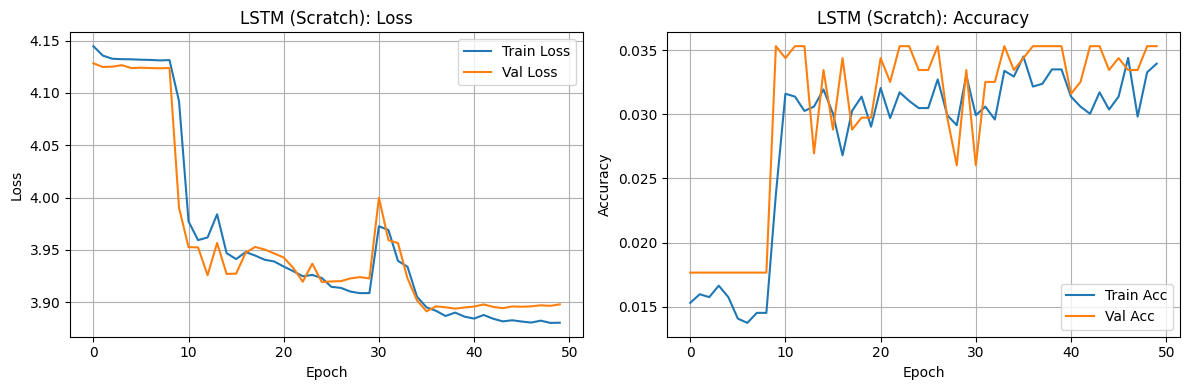

In [64]:
# Vẽ biểu đồ training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm_scratch.history['loss'], label='Train Loss')
plt.plot(history_lstm_scratch.history['val_loss'], label='Val Loss')
plt.title('LSTM (Scratch): Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm_scratch.history['accuracy'], label='Train Acc')
plt.plot(history_lstm_scratch.history['val_accuracy'], label='Val Acc')
plt.title('LSTM (Scratch): Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Nhiệm vụ 5: Đánh giá, So sánh và Phân tích

### 5.1. So sánh Định lượng

In [65]:
# Tạo bảng so sánh kết quả
results = pd.DataFrame({
    'Pipeline': [
        'TF-IDF + Logistic Regression',
        'Word2Vec (Avg) + Dense',
        'Embedding (Pre-trained) + LSTM',
        'Embedding (Scratch) + LSTM'
    ],
    'Accuracy': [
        accuracy_tfidf_lr,
        test_acc_w2v,
        test_acc_lstm_pre,
        test_acc_lstm_scratch
    ],
    'F1-score (Macro)': [
        f1_macro_tfidf_lr,
        f1_macro_w2v,
        f1_macro_lstm_pre,
        f1_macro_lstm_scratch
    ],
    'Test Loss': [
        'N/A',
        f"{test_loss_w2v:.4f}",
        f"{test_loss_lstm_pre:.4f}",
        f"{test_loss_lstm_scratch:.4f}"
    ]
})

print("="*80)
print("BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH")
print("="*80)
print(results.to_string(index=False))
print("="*80)

BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH
                      Pipeline  Accuracy  F1-score (Macro) Test Loss
  TF-IDF + Logistic Regression  0.833643          0.830032       N/A
        Word2Vec (Avg) + Dense  0.588290          0.547765    1.4335
Embedding (Pre-trained) + LSTM  0.530669          0.504449    1.6899
    Embedding (Scratch) + LSTM  0.035316          0.002303    3.8935


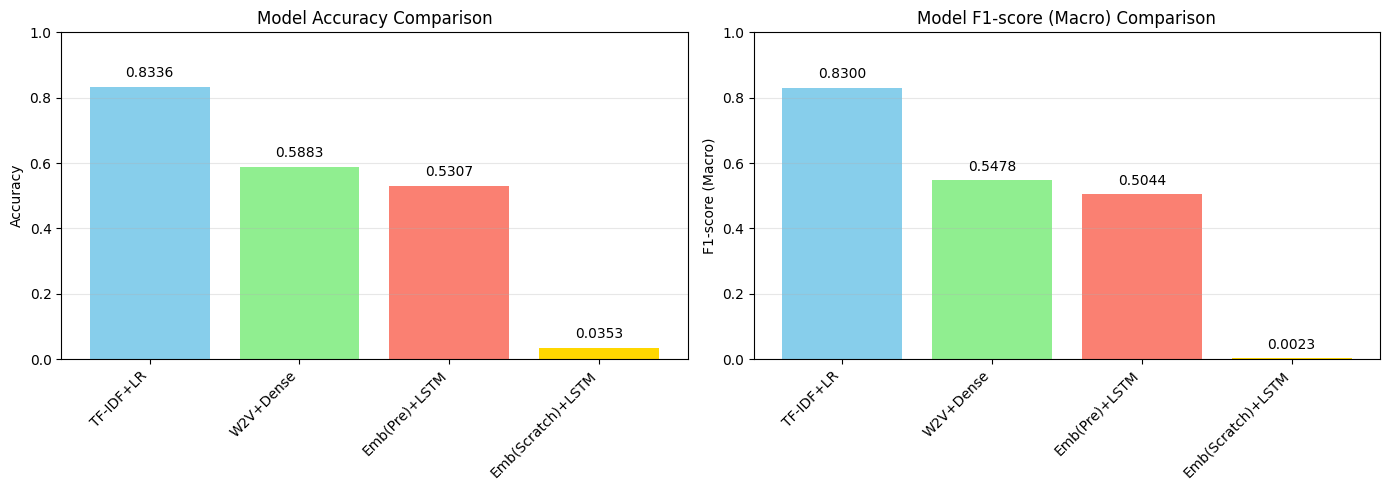

In [66]:
# Visualize so sánh
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(range(len(results)), results['Accuracy'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0].set_xticks(range(len(results)))
axes[0].set_xticklabels(['TF-IDF+LR', 'W2V+Dense', 'Emb(Pre)+LSTM', 'Emb(Scratch)+LSTM'], rotation=45, ha='right')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(results['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

# F1-score comparison
axes[1].bar(range(len(results)), results['F1-score (Macro)'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[1].set_xticks(range(len(results)))
axes[1].set_xticklabels(['TF-IDF+LR', 'W2V+Dense', 'Emb(Pre)+LSTM', 'Emb(Scratch)+LSTM'], rotation=45, ha='right')
axes[1].set_ylabel('F1-score (Macro)')
axes[1].set_title('Model F1-score (Macro) Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(results['F1-score (Macro)']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 5.2. Phân tích Định tính - Kiểm tra trên Các Câu Khó

In [67]:
# Các câu test khó (có phủ định, cấu trúc phức tạp)
difficult_sentences = [
    "can you remind me to not call my mom",
    "is it going to be sunny or rainy tomorrow",
    "find a flight from new york to london but not through paris",
    "don't forget to turn off the lights",
    "I want to order pizza but not with pepperoni"
]

print("="*80)
print("PHÂN TÍCH ĐỊNH TÍNH - DỰ ĐOÁN TRÊN CÁC CÂU KHÓ")
print("="*80)

for idx, sentence in enumerate(difficult_sentences, 1):
    print(f"\n{idx}. Test sentence: '{sentence}'")
    print("-" * 80)

    # TF-IDF + LR
    pred_tfidf = tfidf_lr_pipeline.predict([sentence])[0]
    print(f"   TF-IDF + LR:          {label_encoder.classes_[pred_tfidf]}")

    # Word2Vec + Dense
    sentence_vec = sentence_to_avg_vector(sentence, w2v_model).reshape(1, -1)
    pred_w2v = w2v_dense_model.predict(sentence_vec, verbose=0)
    pred_w2v_class = label_encoder.classes_[np.argmax(pred_w2v)]
    print(f"   Word2Vec + Dense:     {pred_w2v_class}")

    # LSTM Pre-trained
    sentence_seq = tokenizer.texts_to_sequences([sentence])
    sentence_pad = pad_sequences(sentence_seq, maxlen=max_len, padding='post')
    pred_lstm_pre = lstm_pretrained_model.predict(sentence_pad, verbose=0)
    pred_lstm_pre_class = label_encoder.classes_[np.argmax(pred_lstm_pre)]
    print(f"   LSTM (Pre-trained):   {pred_lstm_pre_class}")

    # LSTM Scratch
    pred_lstm_scratch = lstm_scratch_model.predict(sentence_pad, verbose=0)
    pred_lstm_scratch_class = label_encoder.classes_[np.argmax(pred_lstm_scratch)]
    print(f"   LSTM (Scratch):       {pred_lstm_scratch_class}")

PHÂN TÍCH ĐỊNH TÍNH - DỰ ĐOÁN TRÊN CÁC CÂU KHÓ

1. Test sentence: 'can you remind me to not call my mom'
--------------------------------------------------------------------------------
   TF-IDF + LR:          calendar_set
   Word2Vec + Dense:     social_post
   LSTM (Pre-trained):   social_post
   LSTM (Scratch):       recommendation_events

2. Test sentence: 'is it going to be sunny or rainy tomorrow'
--------------------------------------------------------------------------------
   TF-IDF + LR:          weather_query
   Word2Vec + Dense:     weather_query
   LSTM (Pre-trained):   weather_query
   LSTM (Scratch):       recommendation_events

3. Test sentence: 'find a flight from new york to london but not through paris'
--------------------------------------------------------------------------------
   TF-IDF + LR:          transport_query
   Word2Vec + Dense:     recommendation_locations
   LSTM (Pre-trained):   social_post
   LSTM (Scratch):       recommendation_events

4. Test s

### 5.3. Phân tích Chi tiết Một Câu

In [68]:
# Chọn một câu để phân tích chi tiết
analyze_sentence = "can you remind me to not call my mom"

print("="*80)
print(f"PHÂN TÍCH CHI TIẾT CÂU: '{analyze_sentence}'")
print("="*80)

# Tokenize
tokens = analyze_sentence.split()
print(f"\nTokens: {tokens}")

# Sequence
seq = tokenizer.texts_to_sequences([analyze_sentence])[0]
print(f"Sequence (token IDs): {seq}")

# Word to index mapping
print("\nWord to Index mapping:")
for word in tokens:
    idx = tokenizer.word_index.get(word, 0)
    print(f"  {word:15s} -> {idx:5d}")

# Predictions with confidence scores
sentence_pad = pad_sequences([seq], maxlen=max_len, padding='post')

print("\n" + "="*80)
print("PREDICTIONS WITH CONFIDENCE SCORES:")
print("="*80)

# LSTM Pre-trained
pred_lstm_pre = lstm_pretrained_model.predict(sentence_pad, verbose=0)[0]
top3_idx_pre = np.argsort(pred_lstm_pre)[-3:][::-1]
print("\nLSTM (Pre-trained) - Top 3 predictions:")
for i, idx in enumerate(top3_idx_pre, 1):
    print(f"  {i}. {label_encoder.classes_[idx]:30s} - Confidence: {pred_lstm_pre[idx]:.4f}")

# LSTM Scratch
pred_lstm_scratch = lstm_scratch_model.predict(sentence_pad, verbose=0)[0]
top3_idx_scratch = np.argsort(pred_lstm_scratch)[-3:][::-1]
print("\nLSTM (Scratch) - Top 3 predictions:")
for i, idx in enumerate(top3_idx_scratch, 1):
    print(f"  {i}. {label_encoder.classes_[idx]:30s} - Confidence: {pred_lstm_scratch[idx]:.4f}")

PHÂN TÍCH CHI TIẾT CÂU: 'can you remind me to not call my mom'

Tokens: ['can', 'you', 'remind', 'me', 'to', 'not', 'call', 'my', 'mom']
Sequence (token IDs): [16, 8, 196, 4, 3, 55, 171, 10, 341]

Word to Index mapping:
  can             ->    16
  you             ->     8
  remind          ->   196
  me              ->     4
  to              ->     3
  not             ->    55
  call            ->   171
  my              ->    10
  mom             ->   341

PREDICTIONS WITH CONFIDENCE SCORES:

LSTM (Pre-trained) - Top 3 predictions:
  1. social_post                    - Confidence: 0.1851
  2. takeaway_query                 - Confidence: 0.1521
  3. takeaway_order                 - Confidence: 0.1453

LSTM (Scratch) - Top 3 predictions:
  1. recommendation_events          - Confidence: 0.0280
  2. general_affirm                 - Confidence: 0.0275
  3. qa_factoid                     - Confidence: 0.0273
